<a href="https://colab.research.google.com/github/shiraeisenberg/genomics_and_play_notebooks/blob/main/deepchemtutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a recreation of another notebook aimed at building familiarity with AI for genomics 

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
import scvi
import scanpy as sc 
import matplotlib.pyplot as plt

#set prefs for figures and plots
sc.set_figure_params(figsize=(5,5))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [4]:
#loading data from scvi-tools built in datasets; this one described in Litviňuková et al. (2020).
data = scvi.data.heart_cell_atlas_subsampled()

INFO     Downloading file at data/hca_subsampled_20k.h5ad                                                          
Downloading...: 100%|██████████| 65714/65714.0 [00:01<00:00, 58509.78it/s]


In [5]:
#preprocess data to remove lowly expressed genes and outliers
sc.pp.filter_genes(data,min_counts=3)

In [6]:
#normalize data for visualization
data.layers["counts"] = data.X.copy() #preserve counts
sc.pp.normalize_total(data,target_sum=1e4)
sc.pp.log1p(data)
data.raw = data # save current state in .raw

In [7]:
#preform feature selection 
sc.pp.highly_variable_genes(
    data,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source"
)

In [8]:
#setup anndata to get annotated
scvi.model.SCVI.setup_anndata(
    data,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"]
    
)

In [9]:
#create and train model 
model = scvi.model.SCVI(data)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [10]:
model.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [13:56<00:00,  1.97s/it, loss=285, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [13:56<00:00,  2.09s/it, loss=285, v_num=1]


In [11]:
#obtaining model outputs
latent = model.get_latent_representation()

In [12]:
#store outputs to original anndata
data.obsm["X_scVI"]=latent

In [13]:
data_subset = data[data.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(data_subset)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [14]:
#denoise
denoised = model.get_normalized_expression(data_subset, library_size=1e4)
denoised.iloc[:5,:5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.512875,0.232016,2.314807,0.029820,4.179015
GAGTCATTCTCCGTGT-1-HCAHeart8287128,1.508090,0.163548,2.367775,0.025795,17.865246
CCTCTGATCGTGACAT-1-HCAHeart7702881,6.018365,0.444795,1.304860,0.196160,3.420927
CGCCATTCATCATCTT-1-H0035_apex,0.268904,0.049079,0.495935,0.146478,5.544110
TCGTAGAGTAGGACTG-1-H0015_septum,0.310951,0.021762,0.434996,0.503284,9.414790


In [15]:
#store normalized values in anndata
data.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

In [17]:
#visualization with batch correction
sc.tl.pca(data) #pca
sc.pp.neighbors(data,n_pcs=30,n_neighbors=20) #neighbors for umap
sc.tl.umap(data,min_dist=0.3)

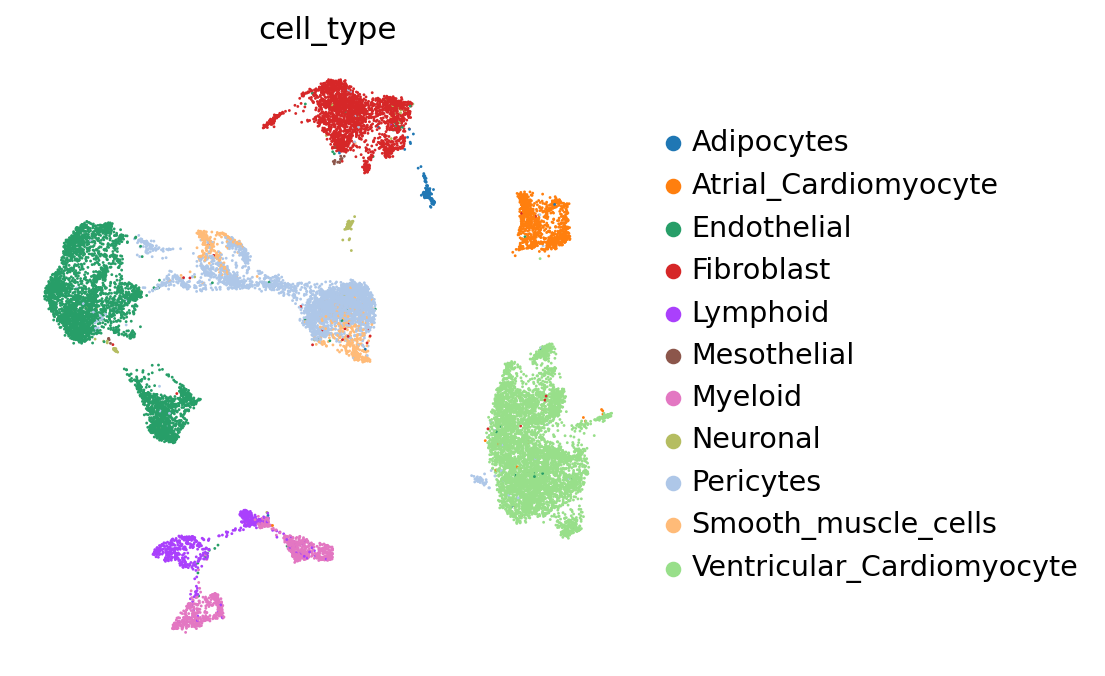

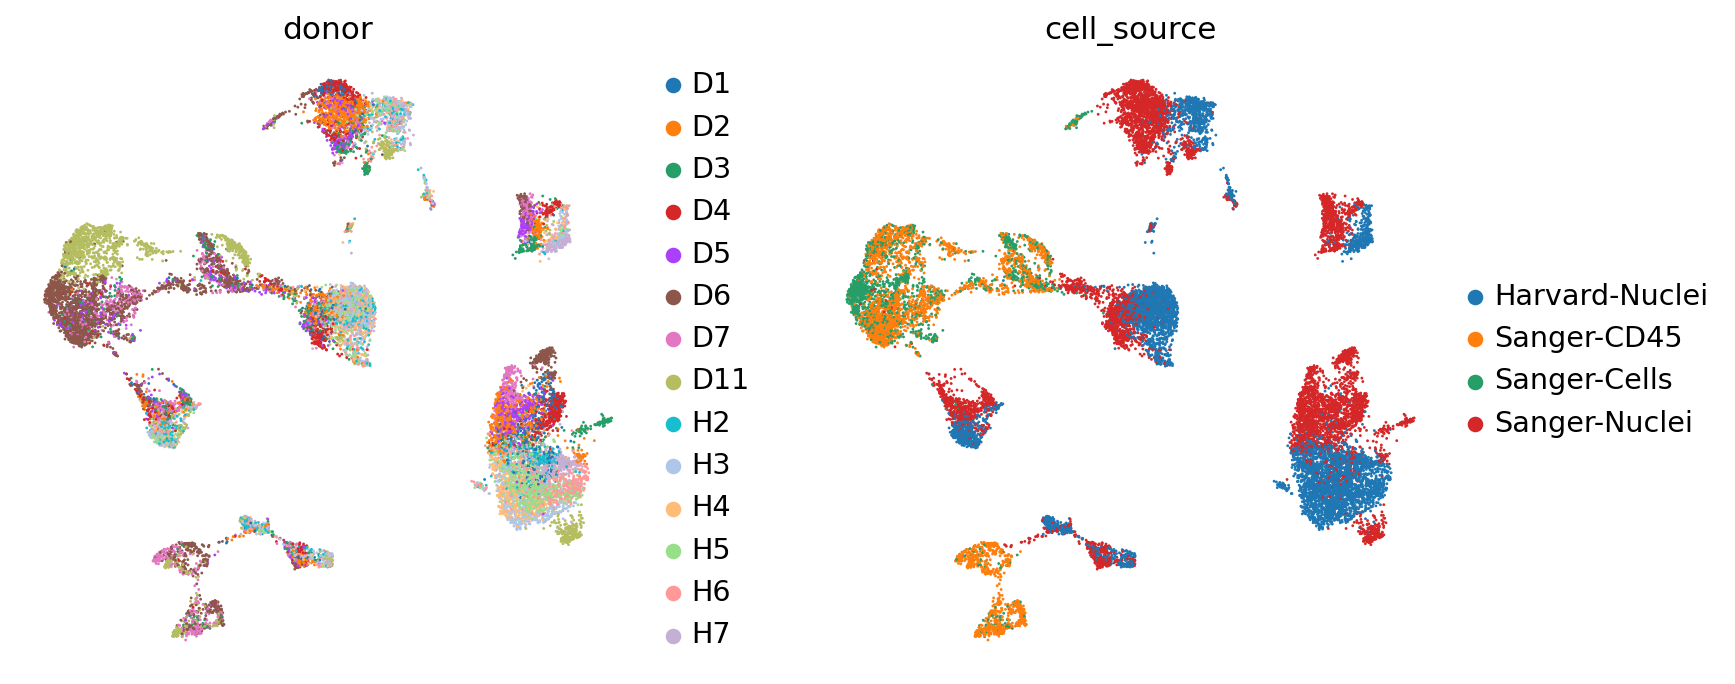

In [18]:
sc.pl.umap(data, 
           color=["cell_type"],
           frameon=False,
           )

sc.pl.umap(data,
           color=["donor","cell_source"],
           ncols=2,
           frameon=False,
           )


In [19]:
#visualize with batch correction 
sc.pp.neighbors(data,use_rep="X_scVI")
sc.tl.umap(data,min_dist=0.3)


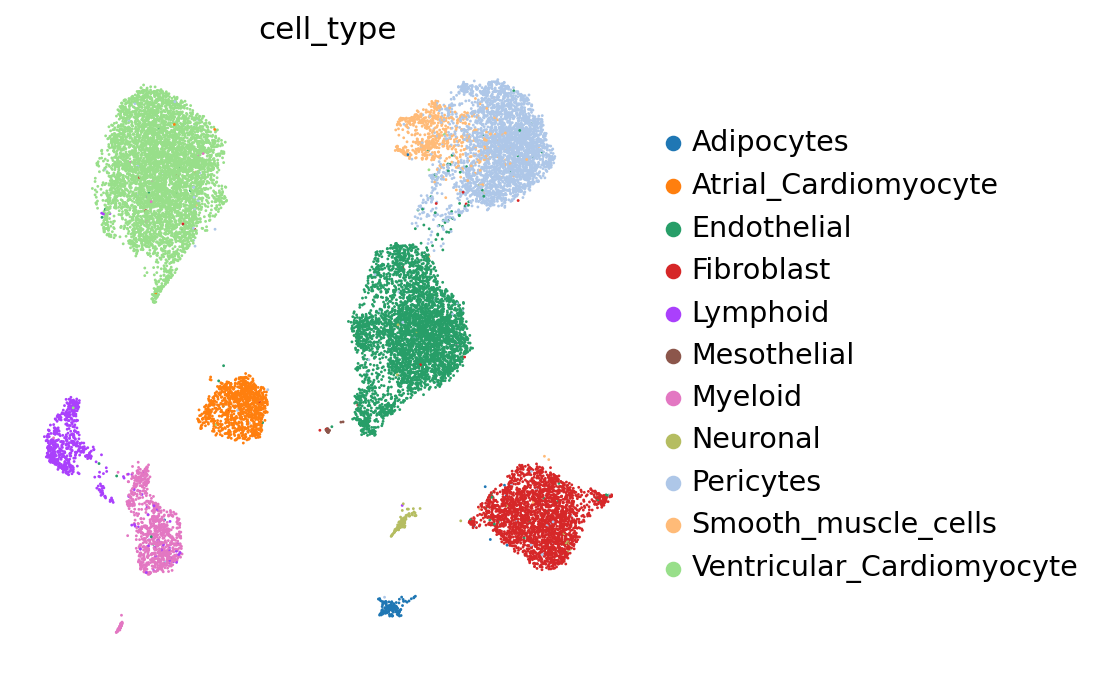

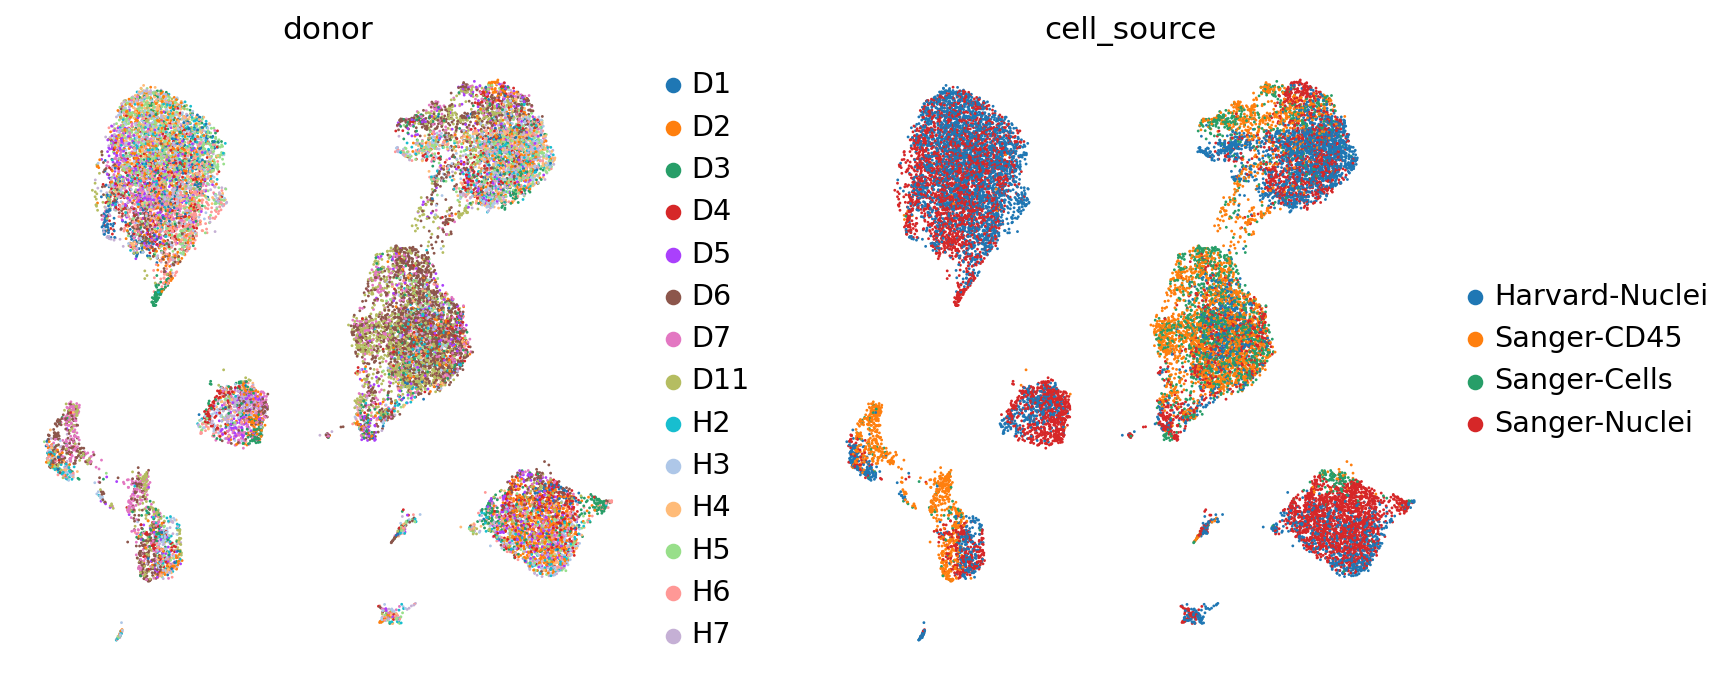

In [20]:
sc.pl.umap(data,
           color=["cell_type"],
           frameon=False
           )

sc.pl.umap(
    data,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

In [21]:
#clustering on scVI latent space

#get neighbors
sc.tl.leiden(data, key_added="leiden_scVI", resolution=0.5)

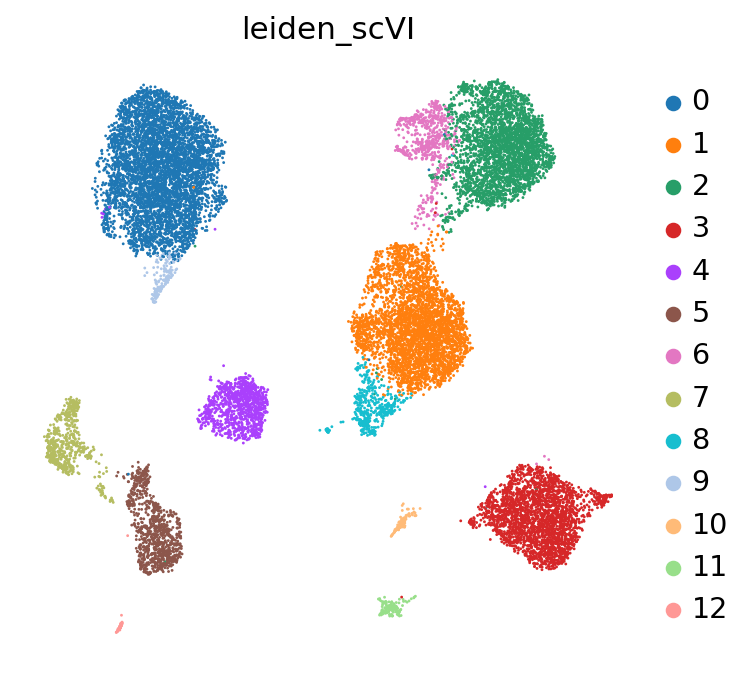

In [22]:
sc.pl.umap(
    data,
    color=["leiden_scVI"],
    frameon=False,
)

In [23]:
#differential expression
data.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ...,
                          'Neuronal', 'Pericytes', 'Smooth_muscle_cells',
                          'Ventricular_Cardiomyocyte']

In [25]:
de_df = model.differential_expression(
    groupby = "cell_type",
    group1 = "Endothelial",
    group2 = "Fibroblast"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
SOX17,0.9994,0.0006,7.417964,0.001618,0.000031,0.0,0.25,6.196153,6.198997,2.048560,...,0.784371,0.006541,0.307617,0.004497,17.128170,0.185868,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
STC1,0.9988,0.0012,6.724225,0.001824,0.000034,0.0,0.25,6.213053,6.166484,2.235080,...,0.785346,0.004088,0.198832,0.003271,17.157606,0.194772,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
SLC9A3R2,0.9986,0.0014,6.569875,0.010405,0.000166,0.0,0.25,5.983375,6.061815,1.652871,...,4.451492,0.045380,0.712339,0.034342,111.582703,1.657324,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
ABCA8,0.9982,0.0018,6.318161,0.000389,0.017574,0.0,0.25,-6.344144,-6.502914,2.155960,...,0.036505,3.181145,0.018496,0.768602,1.501560,183.288528,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
CDH19,0.9982,0.0018,6.318161,0.000283,0.013314,0.0,0.25,-7.267224,-7.367955,2.544933,...,0.049890,3.217938,0.014359,0.672527,1.843119,137.330276,True,Endothelial vs Fibroblast,Endothelial,Fibroblast


In [26]:
#1 vs all DE test
de_df = model.differential_expression(
    groupby="cell_type", 
)
de_df.head()

DE...: 100%|██████████| 11/11 [00:07<00:00,  1.48it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PLIN1,0.9992,0.0008,7.130086,0.004692,0.000049,0.0,0.25,7.921792,7.631880,3.033231,...,2.799999,0.004379,0.806897,0.004325,52.921761,0.196486,True,Adipocytes vs Rest,Adipocytes,Rest
GPD1,0.9990,0.0010,6.906745,0.002210,0.000044,0.0,0.25,6.584513,6.168466,2.777772,...,1.758620,0.007353,0.620690,0.007299,30.203791,0.255079,True,Adipocytes vs Rest,Adipocytes,Rest
CIDEC,0.9984,0.0016,6.436144,0.002310,0.000029,0.0,0.25,7.294376,7.255559,2.654556,...,1.137931,0.001406,0.510345,0.001406,21.809771,0.057564,True,Adipocytes vs Rest,Adipocytes,Rest
GPAM,0.9982,0.0018,6.318161,0.025258,0.000214,0.0,0.25,7.374969,7.373112,2.561751,...,17.372416,0.035791,0.896552,0.031520,280.340485,1.565905,True,Adipocytes vs Rest,Adipocytes,Rest
FASN,0.9980,0.0020,6.212601,0.010461,0.000167,0.0,0.25,6.334327,6.424726,2.188478,...,7.062068,0.025086,0.841379,0.022167,129.074371,1.084626,True,Adipocytes vs Rest,Adipocytes,Rest


In [27]:
#extract top markers for each cluster using DE results
markers = {}
cats = data.obs.cell_type.cat.categories
for i, c in enumerate(cats):
  cid = "{} vs Rest".format(c)
  cell_type_df = de_df.loc[de_df.comparison == cid]
  cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]
  cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
  cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

  markers[c] = cell_type_df.index.tolist()[:3]

In [29]:
sc.tl.dendrogram(data, groupby="cell_type", use_rep="X_scVI")

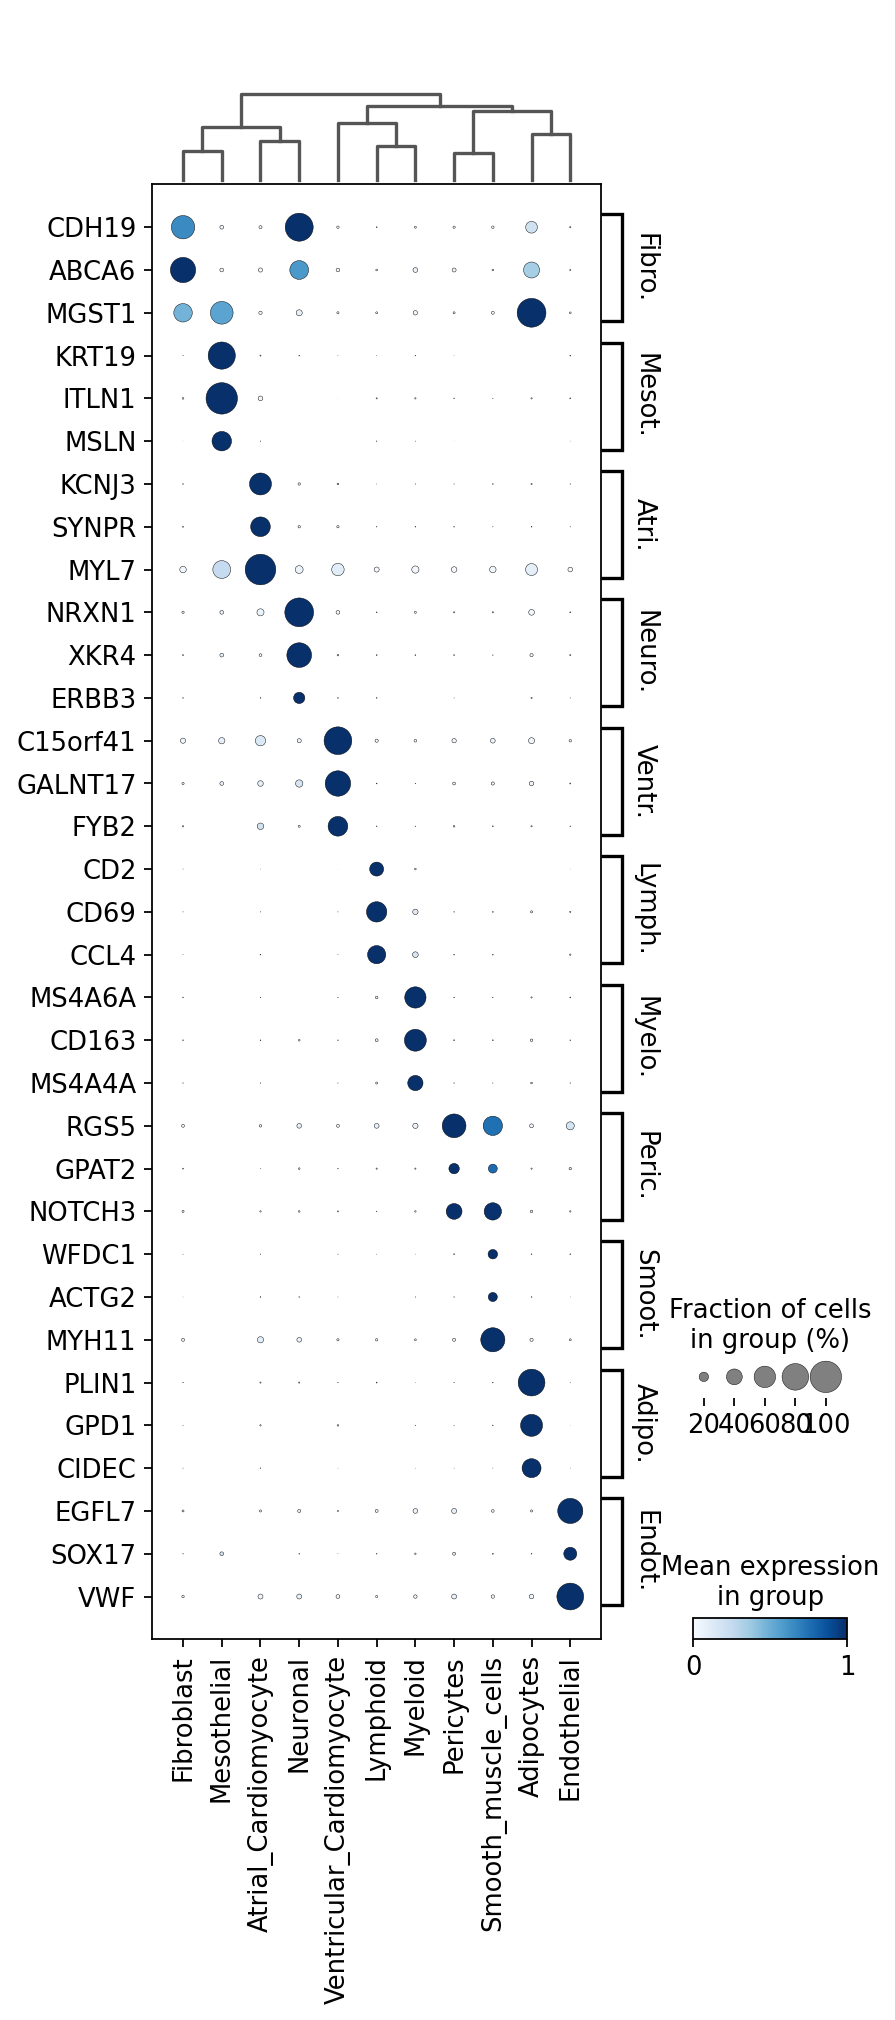

In [32]:
sc.pl.dotplot(
    data, 
    markers, 
    groupby='cell_type', 
    dendrogram=True, 
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

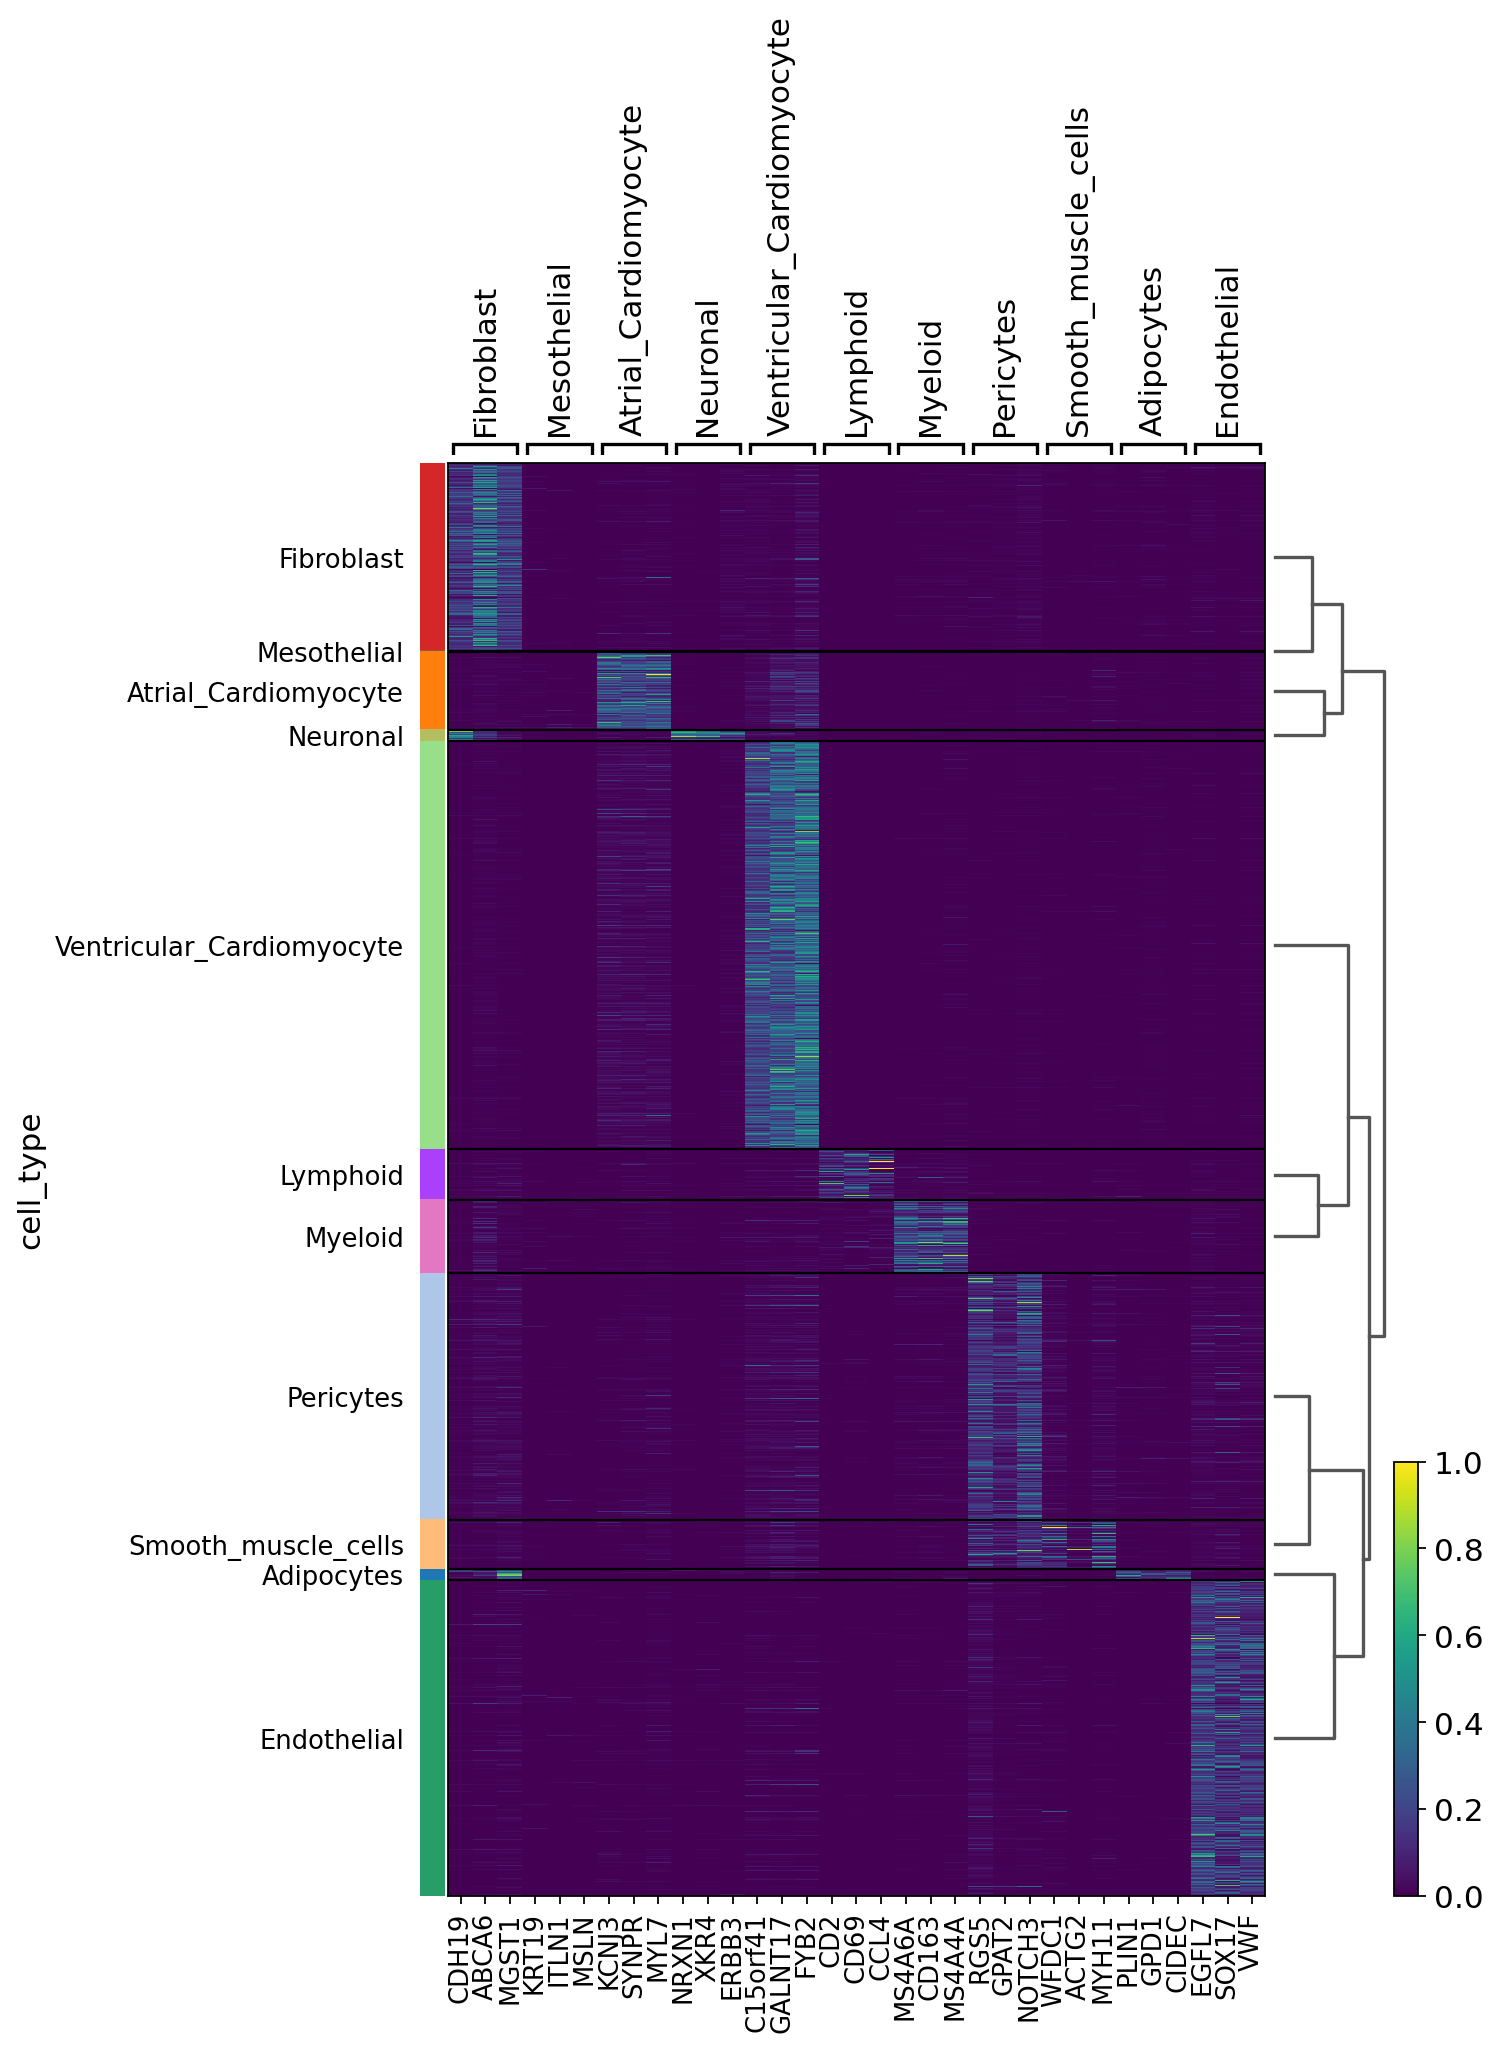

In [35]:
sc.pl.heatmap(
    data,
    markers, 
    groupby='cell_type',
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8,12),
)

In [ ]:
#original tutorial credits
@manual{Bioinformatics, 
 title={Deep Probabilistic Analysis of Single-Cell Omics Data}, 
 organization={DeepChem},
 author={Paiz, Paulina}, 
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Deep_probabilistic_analysis_of_single-cell_omics_data.ipynb}}, 
 year={2022}, 
} 